## Importing all necessary libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

# Preprocessing Libraries
from sklearn.preprocessing import RobustScaler

# Model training libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from collections import Counter
from imblearn.under_sampling import NearMiss               # Undersampling
from imblearn.over_sampling import RandomOverSampler       # Oversampling
from imblearn.combine import SMOTETomek                    # Both Undersampling & Oversampling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Reading/Importing the dataset
### --- Dataset details ---
- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction
- Dataset link---https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

In [2]:
df=pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Checking if there are any null values in our dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Visualization

In [5]:
df[df['isFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


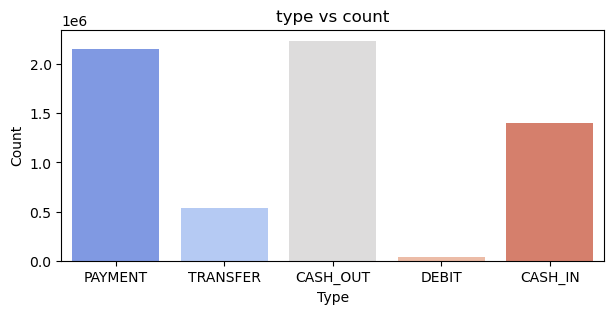

In [6]:
# Countplot of 'type'
plt.figure(figsize=(7,3))
plt.title('type vs count')
sns.countplot(data=df,x='type',palette='coolwarm')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

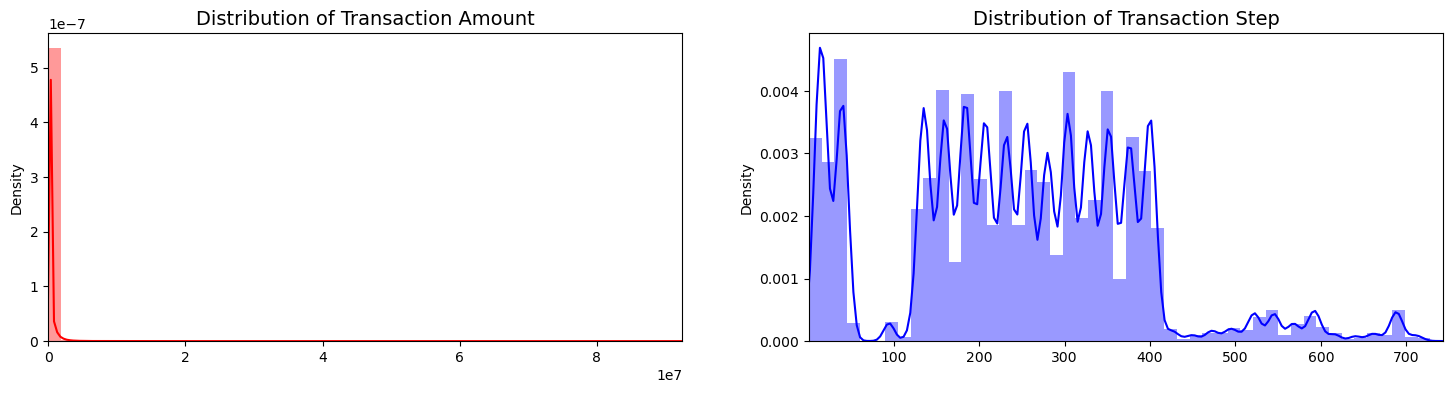

In [7]:
# Plotting subplot for amount and time column
fig, ax = plt.subplots(1, 2, figsize=(18,4))
amount_val = df['amount'].values
time_val = df['step'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Step', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
plt.show()

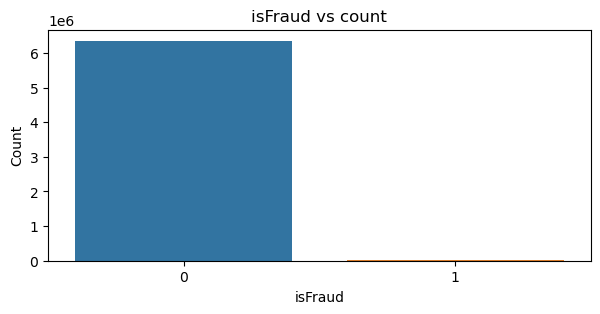

In [8]:
# Countplot of 'isFraud'
plt.figure(figsize=(7,3))
plt.title('isFraud vs count')
sns.countplot(data=df,x='isFraud')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

#### NOTE:- We can see from above visualization it is an imbalanced dataset .

In [9]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [10]:
# Let's look at the percentage of each category in isFraud column(target column)
print("No Frauds:",df['isFraud'].value_counts()[0]/len(df['isFraud'])*100)
print("Frauds:",df['isFraud'].value_counts()[1]/len(df['isFraud'])*100)

No Frauds: 99.87091795518198
Frauds: 0.12908204481801522


In [11]:
numerical=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

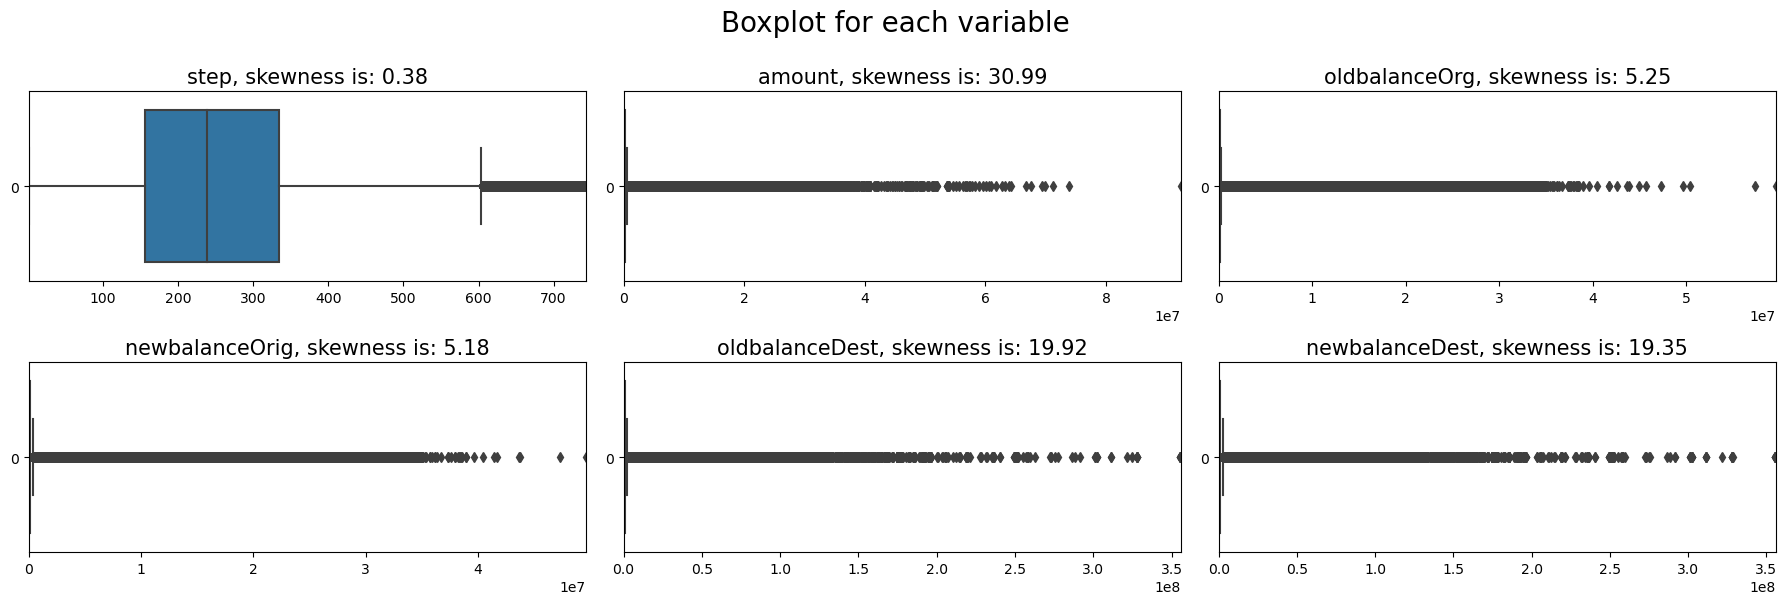

In [12]:
# Boxplot for each variable in numerical list
def boxplots_visual(data,column):
    fig, ax = plt.subplots(2,3,figsize=(18,6))
    fig.suptitle('Boxplot for each variable',y=1, size=20)
    ax=ax.flatten()
    for i,feature in enumerate(column):
        sns.boxplot(data=data[feature],ax=ax[i], orient='h')
        ax[i].set_title(feature+ ', skewness is: '+str(round(data[feature].skew(axis = 0, skipna = True),2)),fontsize=15)
        ax[i].set_xlim([min(data[feature]), max(data[feature])])
boxplots_visual(data=df,column=numerical)
plt.tight_layout()

In [13]:
# Checking nameOrig,nameDest column
nameOrig=df['nameOrig'].unique()
print("Unique in nameOrig:",len(nameOrig))
print(nameOrig)

nameDest=df['nameDest'].unique()
print("Unique in nameDest:",len(nameDest))
print(nameDest)

Unique in nameOrig: 6353307
['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']
Unique in nameDest: 2722362
['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']


In [14]:
# Checking isFlaggedFraud column
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [15]:
# Dropping columns that are not needed
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [16]:
# Applying onehot encoding on type column
df=pd.get_dummies(data=df,columns=['type'],drop_first=True)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [17]:
# We are using RobustScaler to scale down the numerical features as RobustScaler is less prone to outliers
scale=RobustScaler()
for feature in numerical:
    df[feature]=scale.fit_transform(df[feature].values.reshape(-1, 1))
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.329609,-0.332932,1.452991,1.111175,-0.140722,-0.193057,0,0,0,1,0
1,-1.329609,-0.373762,0.065610,0.134375,-0.140722,-0.193057,0,0,0,1,0
2,-1.329609,-0.382380,-0.130708,0.000000,-0.140722,-0.193057,1,0,0,0,1
3,-1.329609,-0.382380,-0.130708,0.000000,-0.118260,-0.193057,1,1,0,0,0
4,-1.329609,-0.323571,0.254820,0.207169,-0.140722,-0.193057,0,0,0,1,0


## Model Training

In [18]:
# Splitting our data into independent and dependent features
x=df.drop('isFraud',axis=1)
y=df['isFraud']

In [19]:
x.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

In [20]:
df[df['isFraud']==1]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,-1.329609,-0.382380,-0.130708,0.0,-0.140722,-0.193057,1,0,0,0,1
3,-1.329609,-0.382380,-0.130708,0.0,-0.118260,-0.193057,1,1,0,0,0
251,-1.329609,-0.368941,-0.106248,0.0,-0.140722,-0.193057,1,0,0,0,1
252,-1.329609,-0.368941,-0.106248,0.0,-0.112937,-0.193057,1,1,0,0,0
680,-1.329609,-0.280261,0.055165,0.0,-0.140722,-0.193057,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6362615,2.815642,1.355693,3.032881,0.0,-0.140722,0.112438,1,1,0,0,0
6362616,2.815642,31.927899,58.679504,0.0,-0.140722,-0.193057,1,0,0,0,1
6362617,2.815642,31.927899,58.679504,0.0,-0.068096,5.544730,1,1,0,0,0
6362618,2.815642,3.968274,7.788223,0.0,-0.140722,-0.193057,1,0,0,0,1


In [21]:
# Feature Importance
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(x,y)
print(model.feature_importances_)

[0.13949863 0.24854646 0.27621822 0.07919396 0.05316671 0.18912531
 0.01061808 0.         0.         0.00363264]


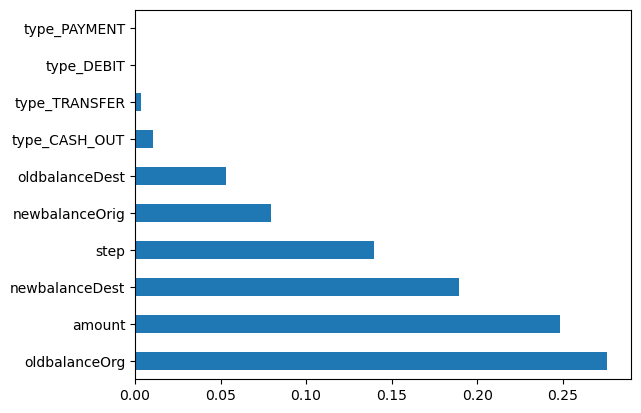

In [22]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [23]:
# Doing train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,train_size=0.7)
# Applying StratifiedKFold
skf=StratifiedKFold(n_splits=3, shuffle=False, random_state=None)

In [24]:
model1=LogisticRegression()
param={'C':10.0 **np.arange(-1,2)}
lrs=RandomizedSearchCV(model1,param,cv=skf,n_jobs=-1,scoring='accuracy')
lrs.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([ 0.1,  1. , 10. ])},
                   scoring='accuracy')

In [25]:
y_pred=lrs.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1906235     124]
 [   1244    1183]]
0.999283314106453
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906359
           1       0.91      0.49      0.63      2427

    accuracy                           1.00   1908786
   macro avg       0.95      0.74      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



##### If you want to see codes for full-functioning fraud detection app
- GitHub link :-https://github.com/Sajid030/fraud_detection